# Strava Data Project

Import necessary libraries

In [38]:
import pandas as pd
import numpy as np
import psycopg2
import calendar
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sqlalchemy import create_engine
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [39]:
ROOT_DIR = os.path.dirname(os.path.abspath('Strava.ipynb'))

json_file = open(os.path.join(ROOT_DIR, 'strava_config1.json'), 'r')
json_str = json_file.read()

redshift_info = json.loads(json_str)['redshift_credentials']

db_name = redshift_info['db_name']
iam_user = redshift_info['iam_user']
iam_password = redshift_info['iam_password']
endpoint = redshift_info['endpoint']
table_name = redshift_info['table_name']

Put table from Redshift into a dataframe

In [40]:
engine = create_engine(f'redshift+psycopg2://{iam_user}:{iam_password}@{endpoint}/{db_name}')
df = pd.read_sql_query(f'SELECT * FROM public.{table_name} ORDER BY start_date DESC',con=engine)

## Lets Take An Initial Look At The Data

In [41]:
df

,id,name,start_date,average_speed_ms,distance_km,elapsed_time_min,total_elevation_gain_m,type,manual_entry
0,3217952831,"I don't do it because it's easy, I do it becau...",2020-03-25 18:42:57,3.73,19.4,86,162.0,Run,False
1,3214321630,An alpha meerkat will piss on other meerkats t...,2020-03-24 18:14:42,3.83,19.7,85,81.0,Run,False
2,3211462218,If today was your last day...,2020-03-23 21:26:55,3.62,17.1,78,75.0,Run,False
3,3208333245,"""on your left"" *ignored* rinse and repeat",2020-03-22 18:17:14,1.87,8.3,73,975.0,Run,False
4,3204919571,With all this extra free time maybe people sho...,2020-03-21 20:31:33,3.70,12.3,55,47.0,Run,False
...,...,...,...,...,...,...,...,...,...
1700,607726595,Morning Run,2016-05-20 18:15:13,2.99,24.3,135,235.0,Run,False
1701,607726584,Afternoon Run,2016-05-18 21:21:11,3.76,4.8,21,84.0,Run,False
1702,607726597,Lunch Run,2016-05-16 20:42:08,3.59,12.6,58,170.0,Run,False
1703,607726580,Afternoon Ride,2016-05-12 22:05:14,7.01,24.8,58,194.0,Ride,False


In [42]:
df.describe()

,id,average_speed_ms,distance_km,elapsed_time_min,total_elevation_gain_m
count,1.705000e+03,1705.000000,1705.000000,1705.000000,1705.000000
mean,1.701081e+09,3.295273,12.805337,70.074487,227.368563
std,7.498481e+08,0.939133,8.368517,57.875177,389.863113
min,6.065143e+08,0.000000,0.000000,1.000000,0.000000
25%,1.052707e+09,3.100000,7.300000,36.000000,30.500000
50%,1.559256e+09,3.460000,11.700000,62.000000,84.000000
75%,2.295682e+09,3.660000,16.100000,83.000000,198.000000
max,3.217953e+09,11.920000,103.400000,737.000000,4042.000000


In [43]:
df.shape

(1705, 9)

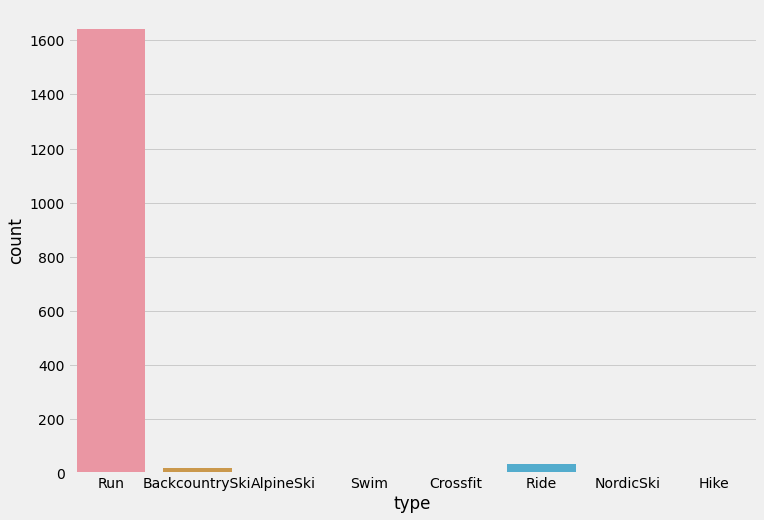

In [44]:
plt.style.use('fivethirtyeight')
dimensions = (11, 8)
fig, ax = plt.subplots(figsize=dimensions)
sns.countplot(ax=ax, x="type", data=df);

In [45]:
df['type'].value_counts()

Run               1642
Ride                36
BackcountrySki      19
Swim                 4
AlpineSki            1
NordicSki            1
Crossfit             1
Hike                 1
Name: type, dtype: int64

### Lets focus on the running data since there isn't substantial data on other activities

In [46]:
df = df[df.type == 'Run']

In [47]:
df

,id,name,start_date,average_speed_ms,distance_km,elapsed_time_min,total_elevation_gain_m,type,manual_entry
0,3217952831,"I don't do it because it's easy, I do it becau...",2020-03-25 18:42:57,3.73,19.4,86,162.0,Run,False
1,3214321630,An alpha meerkat will piss on other meerkats t...,2020-03-24 18:14:42,3.83,19.7,85,81.0,Run,False
2,3211462218,If today was your last day...,2020-03-23 21:26:55,3.62,17.1,78,75.0,Run,False
3,3208333245,"""on your left"" *ignored* rinse and repeat",2020-03-22 18:17:14,1.87,8.3,73,975.0,Run,False
4,3204919571,With all this extra free time maybe people sho...,2020-03-21 20:31:33,3.70,12.3,55,47.0,Run,False
...,...,...,...,...,...,...,...,...,...
1699,607726601,Lunch Run,2016-05-22 20:00:23,3.47,13.7,65,336.0,Run,False
1700,607726595,Morning Run,2016-05-20 18:15:13,2.99,24.3,135,235.0,Run,False
1701,607726584,Afternoon Run,2016-05-18 21:21:11,3.76,4.8,21,84.0,Run,False
1702,607726597,Lunch Run,2016-05-16 20:42:08,3.59,12.6,58,170.0,Run,False


## When do you run?

### By Year

As we can see it looks like the most activities were recorded in 2018

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


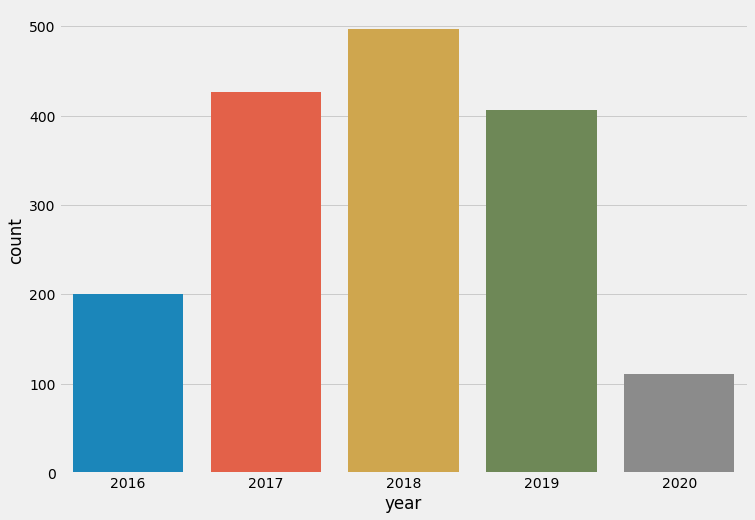

In [48]:
df['year'] = df['start_date'].dt.year
fig, ax = plt.subplots(figsize=dimensions)
sns.countplot(ax = ax, x="year", data=df)

but number of activities doesnt tell the whole story if we look at the overall time spent running has increased almost every year

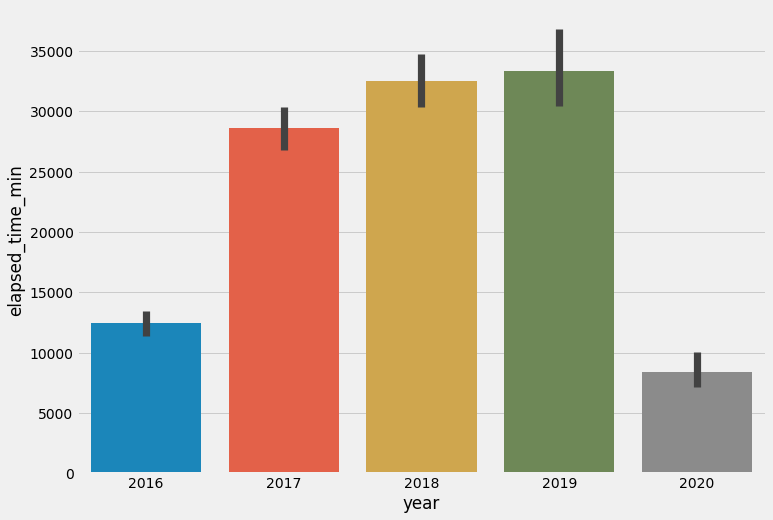

In [49]:
fig, ax = plt.subplots(figsize=dimensions)
sns.barplot(ax =ax, x="year", y="elapsed_time_min", estimator =sum, data=df)

We can see that years have stayed fairly consistent and that 2020 looks like it is on track to be the best year yet

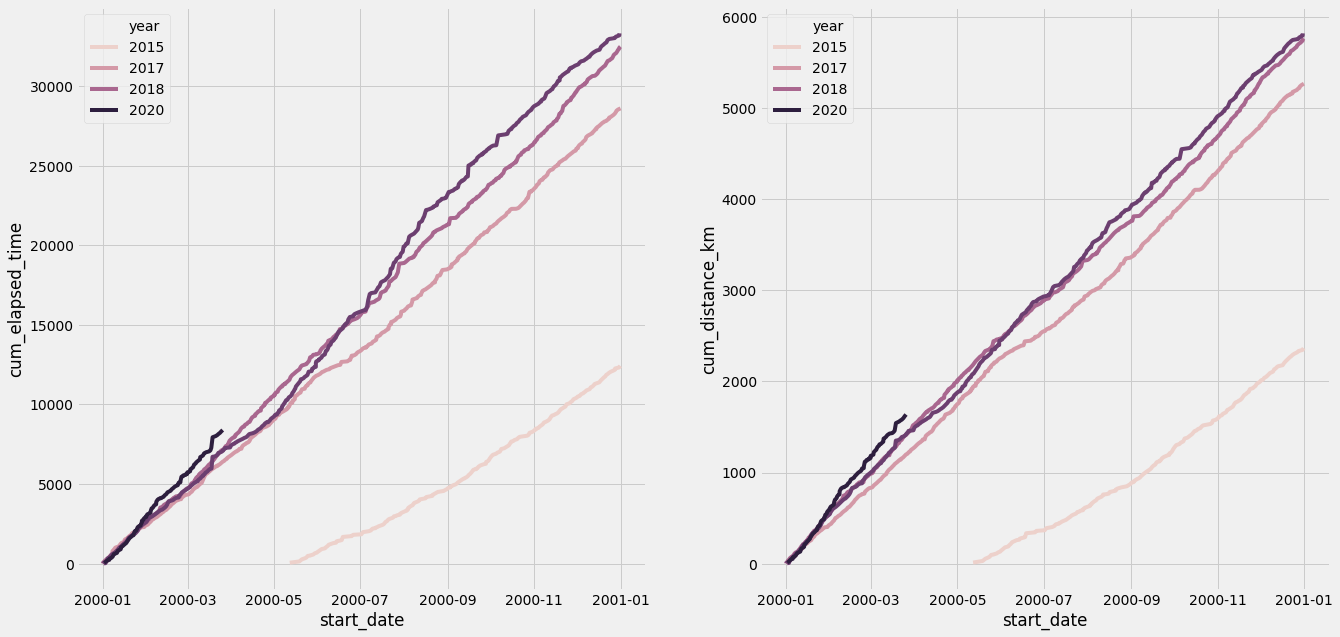

In [50]:
cumulative_df1 = df[['elapsed_time_min', 'start_date', 'year']].copy()
cumulative_df1 = cumulative_df1.sort_values(by=['start_date'])
cumulative_df1['cum_elapsed_time'] = cumulative_df1.groupby(['year'])['elapsed_time_min'].apply(lambda x: x.cumsum())
cumulative_df1['month'] = cumulative_df1['start_date'].dt.month
cumulative_df1['start_date'] = cumulative_df1['start_date'].map(lambda t: t.replace(year=2000))
cumulative_df2 = df[['distance_km', 'start_date', 'year']].copy()
cumulative_df2 = cumulative_df2.sort_values(by=['start_date'])
cumulative_df2['cum_distance_km'] = cumulative_df2.groupby(['year'])['distance_km'].apply(lambda x: x.cumsum())
cumulative_df2['month'] = cumulative_df2['start_date'].dt.month
cumulative_df2['start_date'] = cumulative_df2['start_date'].map(lambda t: t.replace(year=2000))

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1, 2, 1)
sns.lineplot(ax =ax, x="start_date", y="cum_elapsed_time", hue = "year", data=cumulative_df1)
ax = plt.subplot(1, 2, 2)
sns.lineplot(x="start_date", y="cum_distance_km", hue = "year", data=cumulative_df2)

We can also see that the average run times seem to have increased as well

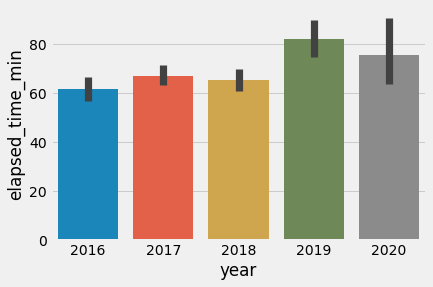

In [51]:
sns.barplot(x="year", y="elapsed_time_min", data=df)

Combine activity time for days with more than one run

In [52]:
heat_map = df[['start_date', 'elapsed_time_min']]
heat_map['start_date'] = heat_map['start_date'].dt.date
heat_map.groupby(['start_date']).sum()
heat_map['weekday'] = df['start_date'].dt.dayofweek
heat_map['month'] = df['start_date'].dt.month
del heat_map['start_date']
heat_map = heat_map.sort_values(by=['month', 'weekday'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Add weekday and month columns to make it easier to input into the heatmap

In [53]:
heat_map = heat_map.pivot_table('elapsed_time_min', 'month', 'weekday')

In [54]:
heat_map = heat_map.rename(lambda x: calendar.month_abbr[x])
heat_map = heat_map.rename(columns = lambda x: calendar.day_abbr[x])

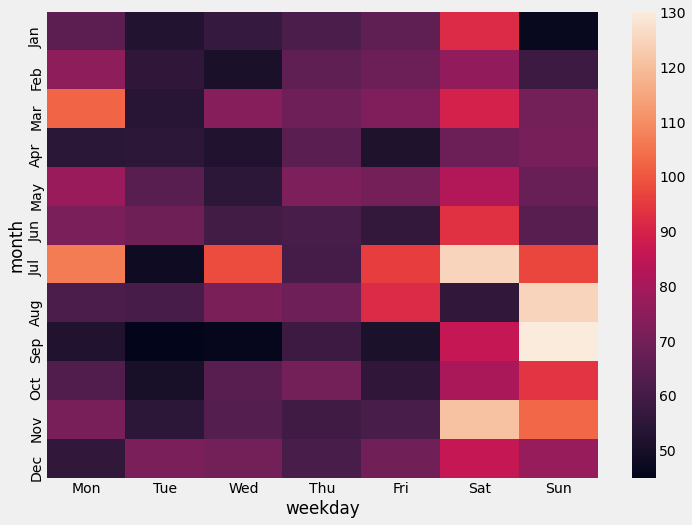

In [64]:
fig, ax = plt.subplots(figsize=dimensions)
sns.heatmap(heat_map, ax = ax)

In [56]:
df

,id,name,start_date,average_speed_ms,distance_km,elapsed_time_min,total_elevation_gain_m,type,manual_entry,year
0,3217952831,"I don't do it because it's easy, I do it becau...",2020-03-25 18:42:57,3.73,19.4,86,162.0,Run,False,2020
1,3214321630,An alpha meerkat will piss on other meerkats t...,2020-03-24 18:14:42,3.83,19.7,85,81.0,Run,False,2020
2,3211462218,If today was your last day...,2020-03-23 21:26:55,3.62,17.1,78,75.0,Run,False,2020
3,3208333245,"""on your left"" *ignored* rinse and repeat",2020-03-22 18:17:14,1.87,8.3,73,975.0,Run,False,2020
4,3204919571,With all this extra free time maybe people sho...,2020-03-21 20:31:33,3.70,12.3,55,47.0,Run,False,2020
...,...,...,...,...,...,...,...,...,...,...
1699,607726601,Lunch Run,2016-05-22 20:00:23,3.47,13.7,65,336.0,Run,False,2016
1700,607726595,Morning Run,2016-05-20 18:15:13,2.99,24.3,135,235.0,Run,False,2016
1701,607726584,Afternoon Run,2016-05-18 21:21:11,3.76,4.8,21,84.0,Run,False,2016
1702,607726597,Lunch Run,2016-05-16 20:42:08,3.59,12.6,58,170.0,Run,False,2016


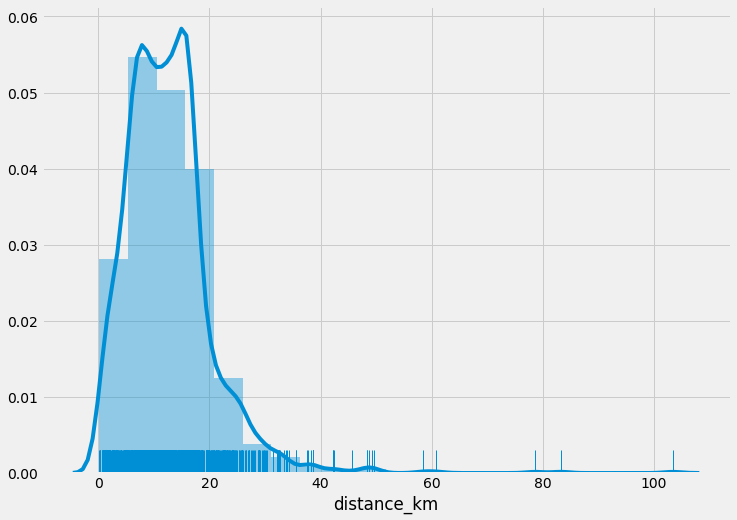

In [65]:
fig, ax = plt.subplots(figsize=dimensions)
sns.distplot(df['distance_km'], bins=20, rug=True, ax = ax);

In [58]:
pd.qcut(df['distance_km'], q=4)

0       (16.1, 103.4]
1       (16.1, 103.4]
2       (16.1, 103.4]
3         (7.2, 11.7]
4        (11.7, 16.1]
            ...      
1699     (11.7, 16.1]
1700    (16.1, 103.4]
1701     (0.199, 7.2]
1702     (11.7, 16.1]
1704     (11.7, 16.1]
Name: distance_km, Length: 1642, dtype: category
Categories (4, interval[float64]): [(0.199, 7.2] < (7.2, 11.7] < (11.7, 16.1] < (16.1, 103.4]]

In [59]:
bins = [0, 5.5, 10.5, 15.5, np.inf]
df['distance_bins_km'] = pd.cut(df['distance_km'], bins = bins)
df['distance_bins_int'] = pd.cut(df['distance_km'], bins = bins, labels = False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1, 2, 1)
sns.lineplot(ax =ax, x="start_date", y="avg speed", hue = "year", data=cumulative_df1)
ax = plt.subplot(1, 2, 2)
sns.lineplot(x="start_date", y="cum_distance_km", hue = "year", data=cumulative_df2)

In [60]:
test = df[df['distance_bins_int'] == 0]

,id,name,start_date,average_speed_ms,distance_km,elapsed_time_min,total_elevation_gain_m,type,manual_entry,year,distance_bins_km,distance_bins_int
52,3093561383,*high wavery voice* I could just show up as a ...,2020-02-11 14:12:03,3.70,4.8,21,0.0,Run,True,2020,"(0.0, 5.5]",0
73,3052442158,If we can make a pipeline from Canada then why...,2020-01-29 01:21:45,3.83,4.8,21,0.0,Run,True,2020,"(0.0, 5.5]",0
89,3026727554,The prophet in red was one of the only people ...,2020-01-19 22:48:45,3.15,5.0,26,24.0,Run,False,2020,"(0.0, 5.5]",0
153,2894079789,TM,2019-11-27 00:25:01,3.83,4.8,21,0.0,Run,True,2019,"(0.0, 5.5]",0
163,2874818547,Afternoon Run,2019-11-18 21:13:37,2.91,4.8,27,24.0,Run,False,2019,"(0.0, 5.5]",0
...,...,...,...,...,...,...,...,...,...,...,...,...
1671,619739481,Mount Marathon Cool Down,2016-06-21 22:15:55,3.03,4.7,25,65.0,Run,False,2016,"(0.0, 5.5]",0
1676,609618948,Maintenance,2016-06-15 00:57:42,3.33,5.1,25,41.0,Run,False,2016,"(0.0, 5.5]",0
1678,608348483,Lunch Run,2016-06-13 19:13:47,3.34,5.2,25,99.0,Run,False,2016,"(0.0, 5.5]",0
1695,607726540,Lunch Run,2016-05-26 19:43:58,3.60,5.1,23,43.0,Run,False,2016,"(0.0, 5.5]",0


In [62]:
x = widgets.Dropdown(
    options=["elapsed_time_min", "distance_km", "total_elevation_gain_m", "average_speed_ms"],
    value='elapsed_time_min',
    description='x axis:',
    disabled=False,
)
x

Dropdown(description='x axis:', options=('elapsed_time_min', 'distance_km', 'total_elevation_gain_m', 'average…

In [63]:
sns.scatterplot(x=x.value, y=y.value, alpha = .3, data=df.query(f'start_date >= {year_start.value} & start_date <= {year_end.value}'));

NameError: name 'y' is not defined

In [ ]:
df['year'] = df['start_date'].dt.year
sns.relplot(x="elapsed_time_min", y="distance_km", hue= "year", alpha=.5, palette="muted",
            height=6, data=df)